In [1]:
%cd ..

/Users/anthony/Documents/UW/Classes/SP24/CSE_571_Robotics/Project/vlmaps


In [2]:
import os
import torch
root_dir = !pwd
root_dir = root_dir[0]
house = "ZMojNkEp431"
data_dir = os.path.join(root_dir, "data", house, "scans", "raw")
scans = set([file[:-9] for file in os.listdir(os.path.join(data_dir, "depth"))])
map_dir = os.path.join(root_dir, "maps", house)
colors_path = os.path.join(map_dir, "colors.npy")
coordinates_path = os.path.join(map_dir, "coordinates.npy")
features_path = os.path.join(map_dir, "features.npy")

In [3]:
# setup parameters
# @markdown meters per cell size
cs = 0.05 # @param {type: "number"}
voxel_size = 0.05 # @param {type: "number"}
# @markdown map resolution (gs x gs)
gs = 1000 # @param {type: "integer"}
# @markdown camera height (used for filtering out points on the floor)
camera_height = 1.5 # @param {type: "number"}
# @markdown depth pixels subsample rate
depth_sample_rate = 100 # @param {type: "integer"}
# @markdown data where rgb, depth, pose are loaded and map are saved
data_dir = data_dir # @param {type: "string"}

img_save_dir = data_dir
mask_version = 1
crop_size = 480 # 480
base_size = 520 # 520

region_index = 1

In [4]:
def parse_house_file(filename):
  objects = []
  categories = {}
  with open(filename, 'r') as f:
    for line in f:
      # Split line by spaces and remove empty elements
      data = [x for x in line.strip().split(' ') if x]
      # Check for "O" and "C" commands
      if data[0] == "O":
        # Extract object information
        object_dict = {
            "index": int(data[1]),
            "region_index": int(data[2]),
            "category_index": int(data[3]),
            "position": (float(data[4]), float(data[5]), float(data[6])),
            "axis1": (float(data[7]), float(data[8]), float(data[9])),
            "axis2": (float(data[10]), float(data[11]), float(data[12])),
            "radii": (float(data[13]), float(data[14]), float(data[15])),
        }
        objects.append(object_dict)
      elif data[0] == "C":
        # Extract category information (if available)
        category_index = int(data[1])
        category_name = data[3]  # Might be empty string depending on the file format
        categories[category_index] = category_name

  return {"objects": objects, "categories": categories}

def parse_panorama_file(filename):

  data = {}
  with open(filename, 'r') as f:
    for line in f:
      # Split line by spaces and remove empty elements
      elements = [x for x in line.strip().split(' ') if x]
      if len(elements) != 4:
        print(f"Warning: Skipping line with unexpected format: {line}")
        continue
      # Extract information
      if(int(elements[2]) not in data):
        data[int(elements[2])] = []
      data[int(elements[2])].append((elements[1], elements[3])) # region = (Scan, lable)
  return data

house_data = parse_house_file(os.path.join(data_dir, house+".house"))
region_data = parse_panorama_file(os.path.join(data_dir, "panorama_to_region.txt"))
scans = [scan[0] for scan in region_data[region_index]]

In [5]:
import numpy as np

def GetCategoryIndex(cat):
    for cat_index, cat_val in house_data["categories"].items():
        if cat_val == cat:
            return cat_index
    return -1

def GetObject(category, region):
    list_objs = []
    for obj in house_data["objects"]:
        if (obj['category_index'] == category and obj['region_index'] == region):
            list_objs.append(obj)
    return list_objs[0]

def GetObjectPos(category):
    for obj in house_data["objects"]:
        if (obj['category_index'] == category):
            return np.array(obj['position'])
    return None

In [6]:
import numpy as np
import math

def GetExtrinsics(filename):
    lines = []
    with open(filename, "r") as f:
        for line in f:
            lines.append(line.strip())

    return np.array([[float(x) for x in line.split()] for line in lines]).reshape(4, 4)

def GetIntrinsics(filename):
    values = []
    with open(filename, "r") as f:
        line = f.readline()
        #values-> width height fx fy cx cy k1 k2 p1 p2 k3
        values = line.split()
        K = np.eye(3)
        K[0,0] = values[2]
        K[0,2] = values[4]
        K[1,1] = values[3]
        K[1,2] = values[5]
        return K

def GetRotationMatrix(degrees):
    radians = math.radians(degrees)
    rot_ro_cam = np.array([
        [ math.cos(radians), 0, math.sin(radians)],
        [          0,        1,          0],
        [-math.sin(radians), 0, math.cos(radians)]
    ])
    return rot_ro_cam

def GetYRotationMatrix(degrees):
    radians = math.radians(degrees)
    rot_ro_cam = np.array([
        [ math.cos(radians), 0, math.sin(radians)],
        [          0,        1,          0],
        [-math.sin(radians), 0, math.cos(radians)]
    ])
    return rot_ro_cam

def GetXRotationMatrix(degrees):
    radians = math.radians(degrees)
    rot_ro_cam = np.array([
        [ 1, 0, 0],
        [ 0, math.cos(radians), -math.sin(radians)],
        [ 0, math.sin(radians), math.cos(radians)]
    ])
    return rot_ro_cam

def GetZRotationMatrix(degrees):
    radians = math.radians(degrees)
    rot_ro_cam = np.array([
        [math.cos(radians), -math.sin(radians), 0],
        [math.sin(radians), math.cos(radians), 0],
        [ 0, 0, 1]
    ])
    return rot_ro_cam

## Load Model

In [7]:
import clip
# import torch

lang = "door,chair,ground,ceiling,other"
labels = lang.split(",")

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_version = "ViT-B/32"
clip_feat_dim = {'RN50': 1024, 'RN101': 512, 'RN50x4': 640, 'RN50x16': 768,
                'RN50x64': 1024, 'ViT-B/32': 512, 'ViT-B/16': 512, 'ViT-L/14': 768}[clip_version]

print("Loading CLIP model...")
clip_model, preprocess = clip.load(clip_version, device=device)  # clip.available_models()
clip_model.to(device).eval()
print("Done")

Loading CLIP model...
Done


In [8]:
# import torch
import torchvision.transforms as transforms
from lseg.modules.models.lseg_net import LSegEncNet

lang_token = clip.tokenize(labels)
lang_token = lang_token.to(device)
with torch.no_grad():
    text_feats = clip_model.encode_text(lang_token)
    text_feats = text_feats / text_feats.norm(dim=-1, keepdim=True)
text_feats = text_feats.cpu().numpy()
model = LSegEncNet(lang, arch_option=0,
                    block_depth=0,
                    activation='lrelu',
                    crop_size=crop_size)
model_state_dict = model.state_dict()
print("Loading Checkpoints...")
if device == "cpu":
    pretrained_state_dict = torch.load("lseg/checkpoints/demo_e200.ckpt", map_location=torch.device('cpu'))
else:
    pretrained_state_dict = torch.load("lseg/checkpoints/demo_e200.ckpt")
pretrained_state_dict = {k.lstrip('net.'): v for k, v in pretrained_state_dict['state_dict'].items()}
model_state_dict.update(pretrained_state_dict)
model.load_state_dict(pretrained_state_dict)

model.eval()
if device == "cuda":
    model = model.cuda()

norm_mean= [0.5, 0.5, 0.5]
norm_std = [0.5, 0.5, 0.5]
padding = [0.0] * 3
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ]
)

/opt/anaconda3/envs/test/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading Checkpoints...


## Camera params

Focal lengths in pixels: fx  fy

Optical center of the image in pixels: cx cy

intrinsics_matrix [fx 0 cx]  [0 fy cy] [0 0 1]

extrinsics_matrix [:3][:3] -> Rotation matrix, [:3][3] -> translation matrix

In [ ]:
def camera_parameters(file):
  ''' Returns two dicts containing undistorted camera intrinsics (3x3) and extrinsics (4x4),
      respectively, for a given scan. Viewpoint IDs are used as dict keys. '''
  intrinsics = {}
  extrinsics = {}
  with open(file) as f:
    pos = -1
    for line in f.readlines():
      if 'intrinsics_matrix' in line:
        intr = line.split()
        C = np.zeros((3, 3), np.double)
        C[0,0] = intr[1] # fx
        C[1,1] = intr[5] # fy
        C[0,2] = intr[3] # cx
        C[1,2] = intr[6] # cy
        C[2,2] = 1.0
        pos = 0
      elif pos >= 0 and pos < 6:
        q = line.find('.jpg')
        camera = line[q-37:q]
        if pos == 0:
          intrinsics[camera[:-2]] = C
        T = np.loadtxt(io.StringIO(line.split('jpg ')[1])).reshape((4,4))
        # T is camera-to-world transform
        extrinsics[camera] = T
        pos += 1
  return intrinsics,extrinsics

camera_parameters_path = os.path.join(root_dir, "data", "ZMojNkEp431","scans", "undistorted", "undistorted_cam_params.conf")
intrinsics,extrinsics = camera_parameters(camera_parameters_path)

## Preview Image

3e1caa061ec04144a0eac5c40da7c04f


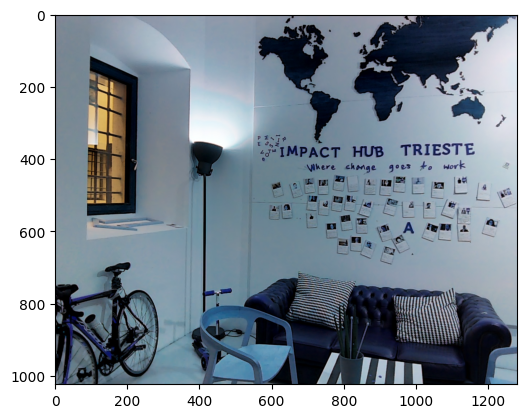

In [39]:
import cv2
import matplotlib.pyplot as plt

scan = "c4df223ecc934eb2bea5b55b8e004a4f"
scan = "2b8074f44cbb43e0949091be7cc1a7b1"
scan = "3e1caa061ec04144a0eac5c40da7c04f"

scan = list(scans)[0]
print(scan)
camera_idx = 1
yaw_idx = 4
color_im = f"{data_dir}/color/{scan}_i{camera_idx}_{yaw_idx}.jpg"
depth_im = f"{data_dir}/depth/{scan}_d{camera_idx}_{yaw_idx}.png"
pose_file = f"{data_dir}/pose/{scan}_pose_{camera_idx}_{yaw_idx}.txt"

image = cv2.imread(color_im)
plt.imshow(image)
plt.show()

## Create Map

In [9]:
import numpy as np
from lseg.additional_utils.models import resize_image, pad_image, crop_image

# Outputs an image segmentation mask as a np array
def get_lseg_feat(model: LSegEncNet, image: np.array, labels, transform, crop_size=480, \
                 base_size=520, norm_mean=[0.5, 0.5, 0.5], norm_std=[0.5, 0.5, 0.5]):
    # vis_image = image.copy()
    if device == "cpu":
        image = transform(image).unsqueeze(0)
    else:
        image = transform(image).unsqueeze(0).cuda()
    img = image[0].permute(1,2,0)
    img = img * 0.5 + 0.5
    
    batch, _, h, w = image.size() # batch is dimension 1, ignoring channel, y, x
    stride_rate = 2.0/3.0
    stride = int(crop_size * stride_rate)

    long_size = base_size
    if h > w:
        height = long_size
        width = int(1.0 * w * long_size / h + 0.5)
        short_size = width
    else:
        width = long_size
        height = int(1.0 * h * long_size / w + 0.5)
        short_size = height

    cur_img = resize_image(image, height, width, **{'mode': 'bilinear', 'align_corners': True})

    if long_size <= crop_size:
        pad_img = pad_image(cur_img, norm_mean,
                            norm_std, crop_size)
        print(pad_img.shape)
        with torch.no_grad():
            outputs, logits = model(pad_img, labels)
        outputs = crop_image(outputs, 0, height, 0, width)
    else:
        if short_size < crop_size:
            # pad if needed
            pad_img = pad_image(cur_img, norm_mean,
                                norm_std, crop_size)
        else:
            pad_img = cur_img
        _,_,ph,pw = pad_img.shape #.size()
        assert(ph >= height and pw >= width)
        h_grids = int(math.ceil(1.0 * (ph-crop_size)/stride)) + 1
        w_grids = int(math.ceil(1.0 * (pw-crop_size)/stride)) + 1

        if device == "cpu":
            with torch.cuda.device_of(image):
                with torch.no_grad():
                    outputs = image.new().resize_(batch, model.out_c,ph,pw).zero_()
                    logits_outputs = image.new().resize_(batch, len(labels),ph,pw).zero_()
                count_norm = image.new().resize_(batch,1,ph,pw).zero_()
        else:
            with torch.cuda.device_of(image):
                with torch.no_grad():
                    outputs = image.new().resize_(batch, model.out_c,ph,pw).zero_().cuda()
                    logits_outputs = image.new().resize_(batch, len(labels),ph,pw).zero_().cuda()
                count_norm = image.new().resize_(batch,1,ph,pw).zero_().cuda()
        # grid evaluation
        for idh in range(h_grids):
            for idw in range(w_grids):
                h0 = idh * stride
                w0 = idw * stride
                h1 = min(h0 + crop_size, ph)
                w1 = min(w0 + crop_size, pw)
                crop_img = crop_image(pad_img, h0, h1, w0, w1)
                # pad if needed
                pad_crop_img = pad_image(crop_img, norm_mean,
                                            norm_std, crop_size)
                with torch.no_grad():
                    output, logits = model(pad_crop_img, labels)
                cropped = crop_image(output, 0, h1-h0, 0, w1-w0)
                cropped_logits = crop_image(logits, 0, h1-h0, 0, w1-w0)
                outputs[:,:,h0:h1,w0:w1] += cropped
                logits_outputs[:,:,h0:h1,w0:w1] += cropped_logits
                count_norm[:,:,h0:h1,w0:w1] += 1
        assert((count_norm==0).sum()==0)
        outputs = outputs / count_norm
        logits_outputs = logits_outputs / count_norm
        outputs = outputs[:,:,:height,:width]
        logits_outputs = logits_outputs[:,:,:height,:width]
    outputs = outputs.cpu()
    outputs = outputs.numpy() # B, D, H, W
    # predicts = [torch.max(logit, 0)[1].cpu().numpy() for logit in logits_outputs]
    # pred = predicts[0]

    return outputs

def load_depth(depth_filepath):
    with open(depth_filepath, 'rb') as f:
        depth = np.load(f)
    return depth

### Reference Extrinsic

In [10]:
pose_file = f"{data_dir}/pose/{next(iter(scans))}_pose_{1}_{1}.txt"
extr = GetExtrinsics(pose_file)
# extr = np.eye(4)
init_tf_inv = np.linalg.inv(extr)

### Create Map

In [11]:
from utils.voxel import Voxel, GetVoxelCoor
from utils.clip_mapping_utils import get_sim_cam_mat, project_point
from tqdm import tqdm
import cv2

GET_FEATURES = True

lang = "ground,other"
labels = lang.split(",")

voxel_list = {}

def Run(color_im, depth_im, ext_mat, inv_int_mat):
    bgr = cv2.imread(color_im)
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    feat_dim = 1
    if GET_FEATURES:
        pix_feats = get_lseg_feat(model, rgb, labels, transform, crop_size, base_size, norm_mean, norm_std)
        feat_cam_mat = get_sim_cam_mat(pix_feats.shape[2], pix_feats.shape[3])#416/520
        feat_dim = clip_feat_dim

    depth = cv2.imread(depth_im, cv2.IMREAD_ANYDEPTH)
    depth = depth / 4000

    h = depth.shape[0]
    w = depth.shape[1]

    y,x = np.indices((h,w))
    homo_pixels = np.vstack((x.flatten(),y.flatten(),np.ones((x.size))))
    rays = inv_int_mat @ homo_pixels
    pc = rays * depth.flatten()
    mask = pc[2, :] > 0.1
    pc = pc[:, mask]
    rgb = rgb.reshape(-1,3)
    rgb = rgb[mask, :]
    rgb = rgb / 255.0
    pc_homo = np.vstack([pc, np.ones((1, pc.shape[1]))])

    k = np.linalg.inv(inv_int_mat)
    scaleX = pix_feats.shape[3] / w
    scaleY = pix_feats.shape[2] / h
    cam_mat = np.eye(3)
    cam_mat[0, 0] = k[0,0] * scaleX
    cam_mat[1, 1] = k[1,1] * scaleY
    cam_mat[0, 2] = k[0,2] * scaleX
    cam_mat[1, 2] = k[1,2] * scaleY

    new_depths = depth.flatten()[mask]
    rays = pc / new_depths
    test = cam_mat @ rays
    test = np.floor(test+0.5).astype(int)

    pose = init_tf_inv @ ext_mat
    p_global = pose @ pc_homo
    p_global = p_global[:3, :]
    voxels_coor = np.floor(p_global.T / voxel_size).astype(int)

    for v_coor, point_local, color, pixels in zip(voxels_coor, pc.T, rgb, test[:2].T):

        voxel_key = str(v_coor[0]) + "," + str(v_coor[1]) + "," + str(v_coor[2])
        if voxel_key not in voxel_list:
            voxel_list[voxel_key] = Voxel(v_coor, feat_dim)
        voxel_list[voxel_key].update_color(color)

        if GET_FEATURES:
            px, py, pz = project_point(feat_cam_mat, point_local)
            if not (px < 0 or py < 0 or px >= pix_feats.shape[3] or py >= pix_feats.shape[2]):
                feat = pix_feats[0, :, py, px]
                voxel_list[voxel_key].update_feature(feat)

            # if ( pixels[1] < pix_feats.shape[2] and pixels[0] < pix_feats.shape[3]):    
            #     feat = pix_feats[0, :, pixels[1], pixels[0]]
            #     voxel_list[voxel_key].update_feature(feat)

for scan in list(scans):
    print(scan)
    for camera_idx in range(1,3):
        print("cam")
        intrinsic_file = f"{data_dir}/intrinsics/{scan}_intrinsics_{camera_idx}.txt"
        intr = GetIntrinsics(intrinsic_file)
        inv_intr_mat = np.linalg.inv(intr)

        for yaw_idx in range(6):
            # print("yaw")
            color_im = f"{data_dir}/color/{scan}_i{camera_idx}_{yaw_idx}.jpg"
            depth_im = f"{data_dir}/depth/{scan}_d{camera_idx}_{yaw_idx}.png"
            pose_file = f"{data_dir}/pose/{scan}_pose_{camera_idx}_{yaw_idx}.txt"
            
            extr = GetExtrinsics(pose_file)
            Run(color_im, depth_im, extr, inv_intr_mat)
print("Done")

__file__:  /Users/anthony/Documents/UW/Classes/SP24/CSE_571_Robotics/Project/vlmaps/examples/context.py
imported path: /Users/anthony/Documents/UW/Classes/SP24/CSE_571_Robotics/Project/vlmaps
3e1caa061ec04144a0eac5c40da7c04f
cam
cam
4967e9252dec465db94b791223a67a2e
cam
cam
6e31c6927a6948a7a32918d626028b8d
cam
cam
deb30eecfa4e49198ba8473ee803622b
cam
cam
e8bc16aba1c747abb860a4f5ad106142
cam
cam
Done


In [12]:
total_coordinates = np.array([i.coordinates for i in voxel_list.values()])
total_colors = np.array([i.colors for i in voxel_list.values()])

In [13]:
features = np.array([i.features for i in voxel_list.values()])

In [11]:
from utils.clip_mapping_utils import save_map
save_map(colors_path, total_colors)
save_map(coordinates_path, total_coordinates)
# save_map(features_path, features)

/Users/anthony/Documents/UW/Classes/SP24/CSE_571_Robotics/Project/vlmaps/maps/ZMojNkEp431/colors.npy is saved.
/Users/anthony/Documents/UW/Classes/SP24/CSE_571_Robotics/Project/vlmaps/maps/ZMojNkEp431/coordinates.npy is saved.


## Load Map from object

In [20]:
from utils.clip_mapping_utils import load_map
from utils.clip_utils import get_text_feats
from utils.mp3dcat import mp3dcat
import numpy as np

colors = np.array([i.colors for i in voxel_grid.values()])
features = np.array([i.features for i in voxel_grid.values()])
coordinates = np.array([i.coordinates for i in voxel_grid.values()])

print(colors.shape)
print(features.shape)
print(coordinates.shape)

(443299, 3, 1)
(443299, 512)
(443299, 3, 1)


## Load Map from directory

In [9]:
from utils.clip_mapping_utils import load_map
from utils.clip_utils import get_text_feats
from utils.mp3dcat import mp3dcat
import numpy as np
import torch

total_coordinates = torch.tensor(load_map(coordinates_path), dtype=torch.int)
total_colors = torch.tensor(load_map(colors_path))
# features = torch.tensor(load_map(features_path), dtype=torch.float32)

__file__:  /Users/anthony/Documents/UW/Classes/SP24/CSE_571_Robotics/Project/vlmaps/examples/context.py
imported path: /Users/anthony/Documents/UW/Classes/SP24/CSE_571_Robotics/Project/vlmaps


## Averaging

In [43]:
min_v, _ = torch.min(total_coordinates, dim=0)

total_coordinates = total_coordinates - min_v

max_v, _ = torch.max(total_coordinates, dim=0)
max_v += 1

grid = torch.zeros((max_v[0]+1, max_v[1]+1, max_v[2]+1, 1), dtype=torch.int32)

for i, coor in enumerate(total_coordinates):
    grid[coor[0], coor[1], coor[2]] = i

kernel_size = 3

new_coord = np.zeros((features.shape[0],3))
new_feat = np.zeros((features.shape))

index = 0
kernel_bound = int(kernel_size/2)
for x in tqdm(range(grid.shape[0]-kernel_bound)):
    for y in range(grid.shape[1]-kernel_bound):
        for z in range(grid.shape[2]-kernel_bound):
            if(grid[x,y,z] == 0):
                continue
            lower_x = 0 if x == 0 else x - kernel_bound
            lower_y = 0 if y == 0 else y - kernel_bound
            lower_z = 0 if z == 0 else z - kernel_bound
            voxel_patch = grid[lower_x:x+kernel_bound+1, lower_y:y+kernel_bound+1, lower_z:z+kernel_bound+1]
            voxel_patch_feat = features[voxel_patch.flatten()[voxel_patch.flatten() != 0]]

            new_feat[index] = torch.mean(voxel_patch_feat, dim=0)
            new_coord[index] = [x,y,z]
            index += 1


100%|██████████| 416/416 [02:30<00:00,  2.77it/s]


## Open Language

In [44]:
lang = "chair, cealing, cushion, floor, other"
# lang = mp3dcat
lang = lang.split(",")
text_feats = get_text_feats(lang, clip_model, clip_feat_dim)

scores_list = new_feat @ text_feats.T

predicts = np.argmax(scores_list, axis=1)

In [14]:
from utils.clip_utils import get_text_feats
# lang = "sofa, plant, towel, sink, food, other"
# lang = mp3dcat # lang is all the matterport classes
lang = "chair, cealing, table, floor, other"
lang = lang.split(",")
text_feats = get_text_feats(lang, clip_model, clip_feat_dim)

scores_list = features @ text_feats.T

predicts = np.argmax(scores_list, axis=1)

## Segment Colors

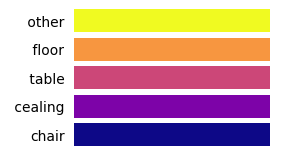

In [15]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt

num_categories = len(lang)

# Choose a colormap (e.g., inferno, plasma, viridis)
cmap = cm.plasma

# Generate an array of values from 0 to 1 representing the colormap index
values = np.linspace(0, 1, num_categories)

# Get RGB colors from the colormap for each value
color_palette = cmap(values)[:,0:3]

# round colors
color_palette = np.round(color_palette, 2)

plt.figure(figsize=(3,num_categories/3))
bars = plt.barh(lang, [1 for i in range(num_categories)], color=color_palette)

plt.gca().xaxis.set_visible(False)
plt.margins(y=0.0)
plt.box(False)
plt.tick_params(left=False)
plt.tight_layout()
plt.show()

## Create Segmented Voxel Grid

In [46]:
from utils.open3d import create_voxel

voxel_grid = create_voxel(new_coord, predicts, color_palette)

In [16]:
from utils.open3d import create_voxel

voxel_grid = create_voxel(total_coordinates, predicts, color_palette, voxel_size)

## Create Real Voxel Grid

In [12]:
from utils.open3d import create_real_rgb_voxel

voxel_grid = create_real_rgb_voxel(total_coordinates, total_colors, voxel_size)

## Display Voxel Grid

In [17]:
from utils.open3d import visualize_map

visualize_map(voxel_grid)

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
running visualization


In [84]:
import open3d as o3d

# obj = GetObject(GetCategoryIndex("bicycle"), region_index)
# obj = GetObject(GetCategoryIndex("armchair"), region_index)
# obj = GetObject(GetCategoryIndex("coffee#table"), region_index)
# obj = GetObject(GetCategoryIndex("lamp"), region_index)
# obj = GetObject(GetCategoryIndex("couch"), region_index)
# obj = GetObject(GetCategoryIndex("table"), region_index)
# obj = GetObject(GetCategoryIndex("arch"), region_index)
obj = GetObject(GetCategoryIndex("bookshelf"), region_index)
# obj = GetObject(GetCategoryIndex("ceiling"), region_index)
radii = np.array([obj["radii"][0], obj["radii"][1], obj["radii"][2]]).reshape(3,1)

axis_dirs = np.array([[obj["axis1"][0], obj["axis1"][1], obj["axis1"][2]],
            [obj["axis2"][0], obj["axis2"][1], obj["axis2"][2]]])

x_length, y_length, z_length = 2 * radii[:, 0]

pos = np.array(obj["position"]).reshape(3,1)

reference_inverted_extrinsics = init_tf_inv

# print(reference_inverted_extrinsics)

center = (reference_inverted_extrinsics @ np.vstack([pos, np.ones((1))]))[:3]
center[0] -= x_length / 2
center[1] -= y_length / 2
center[2] -= z_length / 2

u = axis_dirs[0]
v = axis_dirs[1]

u = u / np.linalg.norm(u)
v = v / np.linalg.norm(v)

v = np.cross(u, v)
v = np.cross(v, u)
v = v / np.linalg.norm(v)

w = np.cross(u, v)
w = w / np.linalg.norm(w)

sorted_indices = np.argsort(radii.reshape(1,3))[0][::-1]

u = u[sorted_indices]
v = v[sorted_indices]
# Assuming radii is a 1D array, sort it directly
radii = radii.reshape(1,3)[0][sorted_indices]

w = np.cross(u, v)
w = w / np.linalg.norm(w)

phi = np.arctan2(reference_inverted_extrinsics[2,1],reference_inverted_extrinsics[2,2])
zhi = np.arctan2(reference_inverted_extrinsics[1,0],reference_inverted_extrinsics[0,0])
theta = np.arctan2(-reference_inverted_extrinsics[2,0],reference_inverted_extrinsics[0,0]/np.cos(zhi))

print(math.degrees(phi))
print(math.degrees(theta))
print(math.degrees(zhi))

# u = u.reshape(3,1)
# v = v.reshape(3,1)
# w = w.reshape(3,1)

# u = (reference_inverted_extrinsics @ np.vstack([u, np.ones((1))]))[:3].reshape(1,3)
# v = (reference_inverted_extrinsics @ np.vstack([v, np.ones((1))]))[:3].reshape(1,3)
# w = (reference_inverted_extrinsics @ np.vstack([w, np.ones((1))]))[:3].reshape(1,3)

# u = u / np.linalg.norm(u)
# v = v / np.linalg.norm(v)
# w = w / np.linalg.norm(w)

# Construct the rotation matrix
Re = np.vstack([u, v, w]).T
rt = np.eye(4)
rt[:3,:3] = Re
Re = (reference_inverted_extrinsics @ rt)[:3,:3]

t= 1
# arch (needs rotation on y-axis)
# u -> -1, 0, 0
# v -> 0, 0, 1

# Table (need 90 rotation on z-axis)
# u -> 0, 1, 0
# v -> -1, 0, 0

# ceiling (need 90 rotation on z-axis)
# u -> 0, 1, 0
# v -> -1, 0 ,0

#couch (needs to be rotate 90 on y-axis and 90 on x-axis)
# u -> -1, 0 ,0
# v -> 0 , 1, 0

# lamp (needs 90 rotation to x-axis, 90 y-axis)
# u -> 0, 0, 1
# v -> -0.923, 0.38, 0

#bicycle (no need for extra rotation)
# u -> 0, 1, 0
# v -> 0, 0, 1

# bookshel (no need for extra rotation)
# u -> 0, 1, 0
# v -> 0, 0, 1



R = GetYRotationMatrix(107)
# R = GetXRotationMatrix(math.degrees(phi)) @ GetYRotationMatrix(math.degrees(theta)) @ GetZRotationMatrix(math.degrees(zhi))
# R = GetYRotationMatrix(math.degrees(zhi))
R2 = GetYRotationMatrix(7)
# R = GetXRotationMatrix(45)
R4 = GetZRotationMatrix(90)

test = reference_inverted_extrinsics[:3,:3]

# [-0.2,0,1],
# [0,1,0],
# [-1,0,0.2]

box = o3d.geometry.TriangleMesh.create_box(width=x_length, height=y_length, depth=z_length)
box.translate(center)
# box.rotate(test)
# box.rotate(R)

# box.rotate(R3)
# box.rotate(R4)
box.rotate(Re)
box.rotate(R2)



90.48910722107469
10.990580506114092
-0.06436541141161649


TriangleMesh with 8 points and 12 triangles.

In [85]:
import open3d as o3d

vis = o3d.visualization.Visualizer()
vis.create_window(visible=True)
vis.get_render_option().background_color = [0,0,0]
vis.add_geometry(voxel_grid)

# x,y,x -> red, green, and blue
axis_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.0)
vis.add_geometry(axis_frame)

vis.add_geometry(box)

# pcd = o3d.geometry.PointCloud()
# pcd.points = o3d.utility.Vector3dVector(object_pos.reshape(1,3))  
# pcd.colors = o3d.utility.Vector3dVector([[1.0, 0.91, 0.0]])
# vis.add_geometry(pcd)
# opt = vis.get_render_option()
# opt.point_size = 40

print("running visualization")
vis.run()
vis.close()

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
running visualization
